<br/>
  <FONT size ="3pt"> MODAL MAP471A : Problem solving en math app </FONT>   
  
---
---
<FONT size ="5pt"> TP déterministe 2 : <center><b>Autour de l'équation eikonale</b>  </center></FONT> 

---
---
<br /> 

Dans ce TP, on cherche à modéliser la propagation (de la lumière par exemple) dans un milieu à indice variable, c'est-à-dire que la vitesse dépend de l'endroit où l'on est.

Le but est de pouvoir calculer le plus court chemin entre un point de départ $(s_x,s_y)$ et un point d'arrivée. Pour ce faire, on calcule pout tout point $(x,y)$ le temps $\phi(x,y)$ mis pour aller de $(s_x,s_y)$ jusqu'à $(x,y)$. On peut montrer que $\phi$ vérifie l'équation eikonale

$$\|\nabla \phi \|=n(x,y), \qquad\phi(s_x,s_y) = 0.$$

Afin de résoudre cette équation, on propose de la réécrire sous la forme  d'une équation instationnaire

$$\frac{\partial \phi}{\partial t} + \|\nabla \phi \|=n(x,y), \qquad \phi(t,s_x,s_y) = 0\qquad\phi(0,x,y)=0.$$

et de chercher des solutions stationnaires (indépendantes du temps) en faisant tendre $t$ vers l'infini.

In [54]:
import numpy as np
import numpy.linalg as lin
import matplotlib.pyplot as plt
from tqdm import tqdm

# Résolution de l'équation eikonale
On va dans un premier temps résoudre l'équation eikonal sur $\phi$ avec le schéma numérique de Lax-Friedrichs.
On propose de mailler le domaine $\Omega=[0,1]^2$ dans lequel l'onde se propage à l'aide d'un pas $h$ constant en $x$ et en $y$.
On prendra dans un premier temps $h=1/64$, mais on modifiera $h$ pour le réduire par la suite.
Le schéma de Lax-Friedrichs consiste à écrire (on utilisera $\phi_{ij} \approx \phi(ih,jh)$)

$$\phi_{ij}^{p+1} = \frac{\phi_{i+1,j}^{p}+\phi_{i-1,j}^{p}+\phi_{i,j+1}^{p}+\phi_{i,j-1}^{p}}{4}-\Delta t H\left(ih,jh,\frac{\phi_{i+1,j}^{p}-\phi_{i-1,j}^{p}}{2h},\frac{\phi_{i,j+1}^{p}-\phi_{i,j-1}^{p}}{2h}\right),$$

où

$$H(x,y,\phi_x,\phi_y) = \sqrt{\phi_x^2+\phi_y^2}-n(x,y).$$

1. Implémenter le schéma de Lax-Friedrichs pour résoudre l'équation eikonal. On prendra par exemple (mais vous pouvez bien sûr tester d'autres paramètres) :
    - $\Delta t=h/2$
    - $h = 1/64$
    - le temps final doit être suffisamment grand pour atteindre un régime stationnaire. On pourra par exemple utiliser un critère d'arrêt.
    - On prendra soin de maintenir la valeur $\phi^p_{i_*,j_*}=0$ au point de départ $(s_x,s_y)$ pour tout $p$. On pourra choisir $(s_x,s_y)=(i_*h,j_*h)$ sur la grille.
    - On prendra également au bord

$$\phi_{1,j}^p = \phi_{2,j}^p, \qquad \phi_{N,j}^p = \phi_{N-1,j}^p,\qquad \phi_{i,1}^p = \phi_{i,2}^p,\qquad\phi_{i,N}^p=\phi_{i,N-1}^p.$$

*Indication :* Penser à bien décomposer les différentes parties de votre algorithme pour simplifier son implémentation. Un exemple modifiable vous est proposé.

In [9]:
def H(x, y, phi_x, phi_y, n):
    return np.sqrt(phi_x**2 + phi_y**2) - n[x,y]

In [12]:
h = 1/64
dt = h/2
phi_0 = np.zeros([int(1/h), int(1/h)])
n = np.ones_like(phi_0)

phi = phi_0

new_phi = np.zeros_like(phi)
for i in range(phi.shape[0]):
    for j in range(phi.shape[1]):
        if i >= 1 and j >=1 and i < phi.shape[0] - 1 and j < phi.shape[0] - 1:
            
            h_x_y = H(i, j, (phi[i+1, j] - phi[i-1,j])/(2*h), (phi[i, j+1] - phi[i, j - 1])/(2* h), n)
            new_phi[i,j] = 1/4 * (phi[i, j +1] + phi[i, j-1] + phi[i-1, j] + phi[i+1,j])  - dt * h_x_y



In [13]:
new_phi

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.0078125, 0.0078125, ..., 0.0078125, 0.0078125,
        0.       ],
       [0.       , 0.0078125, 0.0078125, ..., 0.0078125, 0.0078125,
        0.       ],
       ...,
       [0.       , 0.0078125, 0.0078125, ..., 0.0078125, 0.0078125,
        0.       ],
       [0.       , 0.0078125, 0.0078125, ..., 0.0078125, 0.0078125,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [69]:
# 1.

def LF_iteration(phi : np.ndarray, 
                 dt, 
                 h, 
                 indice
                ):
    """
    Renvoie la nouvelle valeur de phi (après une itération) par le schéma de Lax-Friedrichs
    ----------   
    
    Paramètres :
    -phi    : solution au pas n
    -dt     : pas de temps
    -h      : pas d'espace
    -indice : matrice des indices sigma_ij
    
    Retourne :
    -solution au pas n+1
    """
    new_phi = np.zeros_like(phi)
    for i in range(phi.shape[0]):
        for j in range(phi.shape[1]):
            if i >= 1 and j >=1 and i < phi.shape[0] - 1 and j < phi.shape[1] - 1:
                
                h_x_y = H(
                    i, 
                    j, 
                    (phi[i+1, j] - phi[i-1,j])/(2*h), 
                    (phi[i, j+1] - phi[i, j - 1])/(2* h), 
                    indice
                )
                new_phi[i,j] = 1/4 * (phi[i, j +1] + phi[i, j-1] + phi[i-1, j] + phi[i+1,j]) - dt * h_x_y

    return new_phi

In [82]:
def condition_bord(phi : np.ndarray): 
    """
    Impose une condition de flux nul au bord
    ----------   
    
    Paramètres :
    -phi    : solution au pas n
    
    Retourne :
    -solution avec un flux nul au bord (même valeur à l'intérieur)
    """
    N = len(phi) - 1
    for i in range(phi.shape[0]):
        phi[i, 0] = phi[i, 1]
        phi[i, N] = phi[i, N - 1]
    for j in range(phi.shape[1]):
        phi[0,j] = phi[1,j]
        phi[N, j] = phi[N - 1, j]

    return phi

In [83]:
h = 1/64
dt = h/2
phi_0 = np.zeros([int(1/h), int(1/h)])
n = np.ones_like(phi_0)

In [84]:
phi = LF_iteration(
    phi_0,
    dt,
    h,
    indice= n 
)
phi = condition_bord(phi)

In [85]:
phi

array([[0.0078125, 0.0078125, 0.0078125, ..., 0.0078125, 0.0078125,
        0.0078125],
       [0.0078125, 0.0078125, 0.0078125, ..., 0.0078125, 0.0078125,
        0.0078125],
       [0.0078125, 0.0078125, 0.0078125, ..., 0.0078125, 0.0078125,
        0.0078125],
       ...,
       [0.0078125, 0.0078125, 0.0078125, ..., 0.0078125, 0.0078125,
        0.0078125],
       [0.0078125, 0.0078125, 0.0078125, ..., 0.0078125, 0.0078125,
        0.0078125],
       [0.0078125, 0.0078125, 0.0078125, ..., 0.0078125, 0.0078125,
        0.0078125]])

In [99]:
def LF_eikonal(indice: np.ndarray, 
               depart: np.ndarray, 
               h: float, 
               dt: float, 
               TOL : float = 1e-5, 
               N_max: int = 1_000):
    """
    Renvoie la solution de l'équation eikonal par le schéma de Lax-Friedrichs
    ----------   
    
    Paramètres :
    -indice : matrice des indices sigma_ij
    -depart : point de départ (indices i,j de la maille)
    -TOL    : tolérance pour la condition d'arrêt pour atteindre le régime stationnaire
    -N_max  : nombre maximal d'itérations
    
    Retourne :
    - la solution numérique
    """
    phi = np.zeros([int(1/h), int(1/h)])
    for count in tqdm(range(N_max)):
        new_phi = LF_iteration(
            phi,
            dt,
            h,
            indice
        )

        new_phi = condition_bord(new_phi)
        new_phi[depart[0], depart[1]] = 0
        
        if np.linalg.norm(phi - new_phi) < TOL:
            phi = new_phi
            break
        
        phi = new_phi
    
    return phi

2. Tracer les lignes de niveau de $\phi$ au cours du temps dans le cas où $n(x,y) = 1$ et $(s_x,s_y)=(0.4,0.5)$.
Vérifier que les lignes de niveau sont des cercles.

In [101]:
0.4/h

25.6

In [103]:
h = 1/64
dt = h/2
n = np.ones([int(1/h), int(1/h)])
depart = [int(0.4/h),int(0.5/h)]

phi = LF_eikonal(
    n,
    depart,
    h,
    dt,
    TOL=1e-5
)

 15%|█▌        | 150/1000 [00:02<00:15, 55.72it/s]


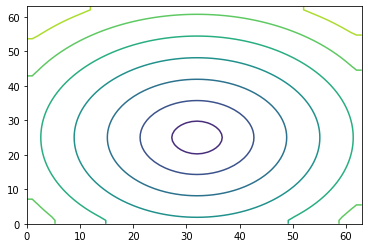

In [107]:
plt.contour(phi)

3. Considérer également le cas d'un dioptre où l'indice est différent dans deux parties du domaine :

$$n(x,y) = \left\{
\begin{array}{ll}
1  &\text{ si } y \leq 0.5\\
10 &\text{ si } y >    0.5
\end{array}\right.$$

et avec $(s_x,s_y)=(0.5,0.1)$. 

Cette expérience correspond à chercher les plus courts chemins pour rallier le point d'une plage (où l'indice est petit et donc la vitesse est grande) à n'importe quel autre point du domaine, y compris au milieu de la mer (l'indice est plus grand, donc la vitesse de déplacement est inférieure).


In [108]:
h = 1/64
dt = h/2
depart = [int(0.5/h),int(0.1/h)]

n = np.ones([int(1/h), int(1/h)])
for i in range(n.shape[0]):
    for j in range(n.shape[1]):
        if j > 0.5/h:
            n[i,j] = 10

In [109]:


phi = LF_eikonal(
    n,
    depart,
    h,
    dt,
    TOL=1e-5
)

 20%|█▉        | 196/1000 [00:03<00:12, 62.32it/s]


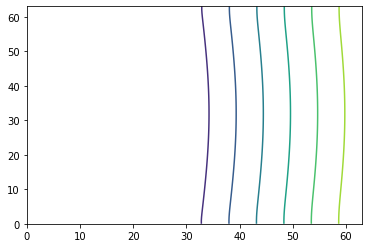

In [111]:
plt.contour(phi)

4. Prendre maintenant pour l'indice la fonction

$$n(x,y) = 1+\sigma\exp(-50(x-l_x)^2 - 100(y-l_y)^2),$$

avec $\sigma = 1.5$, $l_x = 0.6$ et $l_y=0.5$. Tracer les lignes de niveau de $n$, et celles de $\phi$. Vérifier que les lignes de niveau de $\phi$ sont plus resserrées là où $n$ est plus grand.

In [121]:
# 4. 
# paramètres de simulation
sigma = 1.5
h = 1/64
lx = 0.6
ly = 0.5
dt = h/2
depart = [int(0.5/h),int(0.1/h)]

n = np.ones([int(1/h), int(1/h)])
for x in range(n.shape[0]):
    for y in range(n.shape[1]):
        n[x,y] = 1 + sigma * np.exp(-50*(x*h - lx)**2 - 100 * (y*h - ly)**2)




In [122]:
phi = LF_eikonal(
    n,
    depart,
    h,
    dt,
    TOL=1e-5
)

  0%|          | 0/1000 [00:00<?, ?it/s]

 19%|█▉        | 192/1000 [00:02<00:12, 64.88it/s]


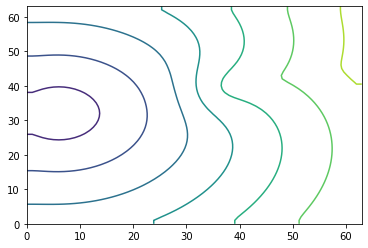

In [123]:
# plots
plt.contour(phi)

# Calcul de chemins

À partir de la solution $\phi$ de l'équation eikonal, on va maintenant chercher le trajet le plus court reliant deux points.

## Rayons lumineux

On appelle $\phi$ la solution obtenue par la méthode précédente au bout d'un temps infini (solution convergée). Comme nous l'avons dit $\phi(X)$ est le temps mis par un rayon pour atteindre $X$ en partant de la source $(s_x,s_y)$. 

Les rayons lumineux se dirigent le long du gradient de $\phi$. Etant donné un point $X_0=(x_0,y_0)$, on considère l'équation différentielle

$$\frac{dX}{dt} = -\frac{\nabla \phi(X(t))}{n^2(X(t))}, \qquad X(0)=X_0. \qquad (1) $$

1. Vérifier analytiquement que 
 
$$\frac{d}{dt}\phi(X(t)) = -1$$

ce qui signifie que le long des trajectoires de l'équation différentielle, on remonte le temps à vitesse constante. Ainsi, la courbe partant de $X_0$ se termine au bout du temps $T=\phi(X_0)$ en $(s_x,s_y)$.

2. Implémenter une fonction qui calcul $\phi(x,y)$ en tout point $(x,y) \in \Omega$ à partir des valeurs de $\phi_{i,j} \approx \phi(ih,jh)$. 
    - Pour cela, on pourra calculer les indices $(i,j)$ des quatres voisins les plus proches $x \in [ih,(i+1)h[$ et $y\in[jh,(j+1)h[$. 
    - Et on calculera une interpolation de $\phi$ basée sur ces quatres valeurs voisines de $\phi_{i,j},\phi_{i+1,j},\phi_{i,j+1},\phi_{i+1,j+1}.$ 
    - Faites de même pour calculer le gradient $\nabla\phi$ en tout point de $\Omega$.

3. Implémenter un schéma d'Euler explicite, puis pour plus de précision un schéma de Heun (voir par exemple https://en.wikipedia.org/wiki/Heun%27s_method).

In [ ]:
# 2.
def cherche_indice(mesh_x, mesh_y, position):
    """
    Cherche les point du maillage les plus proches du point position
    ----------   
    
    Paramètres :
    -mesh_x, mesh_y : vecteurs des points du maillage en x et en y
    -position       : point (vecteur 2x2) dont on cherche les points du maillage le plus proche
    
    Retourne :
    - indices i,j du point x[i], y[j] le plus proche
    """
    
    return 

def interpole_phi(mesh_x, mesh_y, position, phi):    
    """
    Interpole la valeur de phi au point "position"
    ----------   
    
    Paramètres :
    -mesh_x, mesh_y : vecteurs des points du maillage en x et en y
    -position       : point (vecteur 2x2) où l'on cherche à évaluer la fonction phi
    -phi            : matrices des phi_{i,j} ~ phi(x_i,y_j) aux points du maillage 
    
    Retourne :
    - valeur approchée de phi au point "position"
    """ 

    return 

def interpole_grad_phi(mesh_x, mesh_y, position, phi):
    """
    Interpole le gradient de phi au point "position"
    ----------   
    
    Paramètres :
    -mesh_x, mesh_y : vecteurs des points du maillage en x et en y
    -position       : point (vecteur 2x2) où l'on cherche à évaluer la fonction phi
    -phi            : matrices des phi_{i,j} ~ phi(x_i,y_j) aux points du maillage 
    
    Retourne :
    - valeur approchée du gradient de phi au point "position"
    """ 

    return 

In [ ]:
# proposer un test unitaire


In [ ]:
# paramètres de simation


In [ ]:
# plots


In [ ]:
# 3. 
def solve_Euler(mesh_x, mesh_y, depart, phi, indice, N_max):
    """
    Résoud numériquement l'EDO avec un schéma d'Euler explicite
    ----------   
    
    Paramètres :
    -mesh_x, mesh_y : vecteurs des points du maillage en x et en y
    -depart         : point de départ (ou d'arrivée) 
    -phi            : matrice des phi_{i,j} ~ phi(x_i,y_j) aux points du maillage  
    -indice         : matrice des indices aux points du maillage
    -N_max          : nombre d'itérations en temps
    
    Retourne :
    - vecteur des positions X(t^n) à chaque pas de temps
    """ 

    return 

In [ ]:
# proposer un test unitaire


In [ ]:
# paramètres de simulation


In [ ]:
# plots 


In [ ]:
def solve_Heun(mesh_x, mesh_y, depart, phi, indice, N_max):
    """
    Résoud numériquement l'EDO avec un schéma de Heun
    ----------   
    
    Paramètres :
    -mesh_x, mesh_y : vecteurs des points du maillage en x et en y
    -depart         : point de départ (ou d'arrivée) 
    -phi            : matrice des phi_{i,j} ~ phi(x_i,y_j) aux points du maillage  
    -indice         : matrice des indices aux points du maillage
    -N_max          : nombre d'itérations en temps
    
    Retourne :
    - vecteur des positions X(t^n) à chaque pas de temps
    """ 
                   
    return 

In [ ]:
# proposer un test unitaire


In [ ]:
# paramètres de simulation


In [ ]:
# plots 


# Pour aller plus loin

Quelques idées pour approfondir et s'entraîner :

## Choix du point de départ

Demander à l'utilisateur de cliquer sur le dessin à l'endroit souhaité pour $X_0$ et l'on récupèrera les coordonnées grâce à la commande *ginput*.

## Obstacles

Des obstacles sont des endroits où l'indice est infini. Mettre un obstacle au milieu du domaine et constater les changements. En particulier, vérifier que les trajectoires évitent les obstacles.

Le programme précédent permet facilement de calculer les temps d'évacuation d'une pièce possédant des obstacles d'une personne située en $(s_x,s_y)$. Les rayons précédemment calculés représenteront la trajectoire qu'elle doit suivre pour évacuer la pièce au plus vite.

In [ ]:
def indice_funct2(x,y,lx,ly):
    # calcul l'indice au point x,y avec les données lx, ly
    return 

In [ ]:
# paramètres de simulation


In [ ]:
# plots


## L'île

La fonction suivante vous donne la carte d'indice d'une île. L'île contient des montagnes dans lesquelles on se déplace plus difficilement (l'indice est plus élevé). Elle est entourée d'eau, il y a une rivière qui la traverse et un pont par dessus la rivière. 
- Tracer les lignes de niveau de l'indice, ce qui permet d'avoir une carte de l'île.
- Utiliser le programme précédent pour calculer les trajectoires optimales reliant deux points. On demandera à l'utilisateur de cliquer successivement sur le point de départ, ce qui permettra de calculer les lignes de niveau de $\phi$, puis sur le point d'arrivée, ce qui permettra de résoudre l'équation différentielle (1).
- Calculer en particulier les trajectoires optimales pour se rendre d'une plage à l'autre de l'île.

In [ ]:
def indice_ile(x):
    # Renvoie l'indice de l'île
    indice_plage    = 2.
    indice_foret    = 1.
    indice_montagne = 10.
    indice_riviere  = 1.e7
    indice_mer      = 1.e10
    
    if( (x[0]**2+x[1]**2) > 100.):
        val = indice_mer
    else:
        if( (x[0]**2+x[1]**2) > 81.):
            val = indice_plage
        elif( ((x[0]+2.)**2+(x[1]-1.)**2) > 25):
            val = indice_montagne
        else:
            val = indice_foret

        if(2.*x[0]-x[1] > 1. and 2.*x[0]-x[1] < 2.):
            if(x[0]+2.*x[1] > 1. and x[0]+2.*x[1] < 2.):
                val = indice_foret
            else:
                val = indice_riviere

    return val